<h1> IBM Applied Data Science Capstone Project</h1>

This notebook is for the final project of IBM Data Science Professional Certificate course.
Purpose of this notebook is to answer the following question:
<b>"Which city would be best to open up a restaurant and what type of restaurant should one open?"</b>

To answer this question, I will use the following data:
1) List of largest cities (https://en.wikipedia.org/wiki/List_of_largest_cities),
2) List of cities by GDP (https://en.wikipedia.org/wiki/List_of_cities_by_GDP).

The plan is to:
1) Select one of the global cities with the top 20 highest GDP / population,
2) Get trending venues in the city
3) Assess what is trending and recommend a restaurant type for the city

In [1]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import re
import requests
import json
from pandas.io.json import json_normalize
%matplotlib inline 

In [2]:
# Retrieve population data from wikipedia
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_largest_cities').text
soup = BeautifulSoup(website_url, 'lxml')
wiki_table = soup.find('table',{'class':'sortable wikitable plainrowheaders'})
rows = wiki_table.find_all('tr')

In [3]:
# Get wiki table into a dataframe
city = []
nation = []
pop_proper = []
pop_metro = []
pop_urban = []

for row in rows:
    try:
        city.append(row.find('th').find('a').text)
        nation.append(row.find("td").text)
        pop_proper.append(row.find("td").find_next("td").find_next("td").text)
        pop_metro.append(row.find("td").find_next("td").find_next("td").find_next("td").text)
        pop_urban.append(row.find("td").find_next("td").find_next("td").find_next("td").find_next("td").text)
    except:
            pass

df = pd.DataFrame()
df['City'] = city
df['Nation'] = nation
df['Population (Proper)'] = pop_proper
df['Population (Metro)'] = pop_metro
df['Population (Urban)'] = pop_urban

df.head()

,City,Nation,Population (Proper),Population (Metro),Population (Urban)
0,Chongqing,China\n,"30,751,600[8]\n","17,000,000[9]\n","8,165,500[a]\n"
1,Shanghai,China\n,"24,256,800[11]\n","24,750,000[12]\n","23,416,000[b]\n"
2,Beijing,China\n,"21,516,000[13]\n","24,900,000[14]\n","21,009,000\n"
3,Lagos,Nigeria\n,"16,060,303[c]\n","21,000,000[17]\n","13,123,000\n"
4,Dhaka,Bangladesh\n,"8,906,039[18]\n","20,000,000[19]\n",\n


In [4]:
# Clean up data
df.replace({r'\n':''}, inplace=True, regex=True)
df['City'] = df['City'].str.replace(r"\[.*\]","").str.replace(u'\xa0', u'')
df['Nation'] = df['Nation'].str.replace(r"\[.*\]","").str.replace(u'\xa0', u'')
df['Population (Proper)'] = df['Population (Proper)'].str.replace(r"\[.*\]","").str.replace(r'\,',"").str.replace(r' ', '').replace("", '0').astype(int)
df['Population (Metro)'] = df['Population (Metro)'].str.replace(r"\[.*\]","").str.replace(r'\,',"").str.replace(r' ', '').replace("", '0').astype(int)
df['Population (Urban)'] = df['Population (Urban)'].str.replace(r"\[.*\]","").str.replace(r'\,',"").str.replace(r' ', '').replace("", '0').astype(int)

# Set population as the maximum of Proper, Metro, Urban classifications
for row in df.iterrows():
    df.loc[row[0], 'Population'] = max(df.loc[row[0], 'Population (Metro)'], df.loc[row[0], 'Population (Urban)'], df.loc[row[0], 'Population (Proper)'])

df['Population'] = df['Population'].astype(int)
df.sort_values(by=['Population'], ascending=False, inplace=True)
df.head()

,City,Nation,Population (Proper),Population (Metro),Population (Urban),Population
10,Tokyo,Japan,13839910,38140000,38505000,38505000
13,São Paulo,Brazil,12038175,21090791,36842102,36842102
0,Chongqing,China,30751600,17000000,8165500,30751600
20,Jakarta,Indonesia,10075310,30539000,30075310,30539000
19,Seoul,"Korea, South",10197604,12700000,25520000,25520000


In [5]:
# Get the 20 largest cities in each nation
df = df.sort_values('Population', ascending=False).drop_duplicates(['Nation'],keep='first').reset_index(drop=True)
df.drop(columns=['Population (Proper)', 'Population (Metro)', 'Population (Urban)'], inplace=True)

In [6]:
# Retrieve GDP data from wikipedia
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_cities_by_GDP').text
soup = BeautifulSoup(website_url, 'lxml')
wiki_table = soup.find('table',{'class':'wikitable sortable'})
rows = wiki_table.find_all('tr')

In [7]:
# Get wiki table into a dataframe
city = []
nation = []
est1 = []
est2 = []
est3 = []
est4 = []
est5 = []

for row in rows:
    try:
        city.append(row.find("td").text)
        nation.append(row.find("td").find_next("td").text)
        est1.append(row.find("td").find_next("td").find_next("td").find_next("td").text)
        est2.append(row.find("td").find_next("td").find_next("td").find_next("td").find_next("td").text)
        est3.append(row.find("td").find_next("td").find_next("td").find_next("td").find_next("td").find_next("td").text)
        est4.append(row.find("td").find_next("td").find_next("td").find_next("td").find_next("td").find_next("td").find_next("td").text)
        est5.append(row.find("td").find_next("td").find_next("td").find_next("td").find_next("td").find_next("td").find_next("td").find_next("td").text)
    except:
            pass

df2 = pd.DataFrame()
df2['City'] = city
df2['Nation'] = nation
df2['Estimate 1'] = est1
df2['Estimate 2'] = est2
df2['Estimate 3'] = est3
df2['Estimate 4'] = est4
df2['Estimate 5'] = est5

df2.head()

,City,Nation,Estimate 1,Estimate 2,Estimate 3,Estimate 4,Estimate 5
0,Aachen-Liège-Maastricht\n,Germany Belgium Netherlands\n,\n,99.7\n,\n,\n,\n
1,Aberdeen\n,United Kingdom\n,11.3 (2008)[5]\n,\n,\n,\n,\n
2,Abidjan\n,Ivory Coast\n,\n,\n,13\n,\n,\n
3,Abu Dhabi\n,United Arab Emirates\n,119[6]\n,178.3\n,\n,67.1\n,\n
4,Addis Ababa\n,Ethiopia\n,\n,\n,12\n,\n,\n


In [8]:
# Clean up data
df2.replace({r'\n':''}, inplace=True, regex=True)
df2['City'] = df2['City'].str.replace(r"\[.*\]","").str.replace(u'\xa0', u'')
df2['Nation'] = df2['Nation'].str.replace(r"\[.*\]","").str.replace(u'\xa0', u'')
df2['Estimate 1'] = df2['Estimate 1'].str.replace(r"\[.*\]","").str.replace(r"\(.*\)","").str.replace(r'/>', '').str.replace(r'\,',"").str.replace(' ', '').replace("", '0').astype(float)
df2['Estimate 2'] = df2['Estimate 2'].str.replace(r"\[.*\]","").str.replace(r"\(.*\)","").str.replace(r'\,',"").str.replace(r' ', '').replace("", '0').astype(float)
df2['Estimate 3'] = df2['Estimate 3'].str.replace(r"\[.*\]","").str.replace(r"\(.*\)","").str.replace(r'\,',"").str.replace(r' ', '').replace("", '0').astype(float)
df2['Estimate 4'] = df2['Estimate 4'].str.replace(r"\[.*\]","").str.replace(r"\(.*\)","").str.replace(r'\,',"").str.replace(r' ', '').replace("", '0').astype(float)
df2['Estimate 5'] = df2['Estimate 5'].str.replace(r"\[.*\]","").str.replace(r"\(.*\)","").str.replace(r'\,',"").str.replace(r' ', '').replace("", '0').astype(float)

for row in df2.iterrows():
    df2.loc[row[0], 'GDP ($bn)'] = df2.loc[row[0], 'Estimate 1']
    if df2.loc[row[0], 'GDP ($bn)'] == 0:
        df2.loc[row[0], 'GDP ($bn)'] = df2.loc[row[0], 'Estimate 2']
    if df2.loc[row[0], 'GDP ($bn)'] == 0:
        df2.loc[row[0], 'GDP ($bn)'] = df2.loc[row[0], 'Estimate 3']
    if df2.loc[row[0], 'GDP ($bn)'] == 0:
        df2.loc[row[0], 'GDP ($bn)'] = df2.loc[row[0], 'Estimate 4']
    if df2.loc[row[0], 'GDP ($bn)'] == 0:
        df2.loc[row[0], 'GDP ($bn)'] = df2.loc[row[0], 'Estimate 5']

df2['GDP ($bn)'] = df2['GDP ($bn)'].astype(float)
df2.sort_values(by=['GDP ($bn)'], ascending=False, inplace=True)
df2.head()

,City,Nation,Estimate 1,Estimate 2,Estimate 3,Estimate 4,Estimate 5,GDP ($bn)
340,Tokyo,Japan,1893.000,1617.0,1479.0,1874.7,1997.5,1893.000
241,New York,United States,1717.712,1403.0,1406.0,1180.3,1056.4,1717.712
198,Los Angeles,United States,1043.735,860.5,792.0,731.8,632.4,1043.735
305,Seoul,South Korea,738.600,845.9,291.0,233.3,0.0,738.600
256,Paris,France,724.000,715.1,564.0,764.2,0.0,724.000


In [9]:
# Merge GDP data into df
df = df.merge(df2[['City', 'GDP ($bn)']], how='inner', on='City')
df.head()

,City,Nation,Population,GDP ($bn)
0,Tokyo,Japan,38505000,1893.000
1,São Paulo,Brazil,36842102,582.079
2,Chongqing,China,30751600,288.800
3,Jakarta,Indonesia,30539000,186.000
4,Seoul,"Korea, South",25520000,738.600


In [10]:
# Calculate GDP per capita of a each city
df['GDP/capita ($)'] = (df['GDP ($bn)']/df['Population']*1000000000).round(0).astype(int)
df.sort_values(by=['GDP/capita ($)'], ascending=False, inplace=True)
df = df.reset_index(drop=True)

In [11]:
# Retrieve the top 20 cities by GDP/capita
df = df[:20]
df = df.replace({"Czech Republic": "Czechia"})

In [12]:
# Get geospatial coordinates
# Coordinates data downloaded from: https://simplemaps.com/data/world-cities
df3 = pd.read_excel('./worldcities.xlsx')
df3

# Merge coordinate data into df
df = df.merge(df3[['city', 'country', 'lat', 'lng']], how='left', left_on=['City', 'Nation'], right_on= ['city', 'country'])
df.drop(columns=['city', 'country'], inplace=True)
df

,City,Nation,Population,GDP ($bn),GDP/capita ($),lat,lng
0,Singapore,Singapore,5535000,349.5,63144,1.2930,103.8558
1,Paris,France,12405426,724.0,58362,48.8667,2.3333
2,Sydney,Australia,5230330,302.7,57874,-33.9200,151.1852
3,Vienna,Austria,2600000,131.9,50731,48.2000,16.3666
4,Tokyo,Japan,38505000,1893.0,49162,35.6850,139.7514
5,Toronto,Canada,6346088,303.0,47746,43.7000,-79.4200
6,Taipei,Taiwan,7045488,327.3,46455,25.0358,121.5683
7,London,United Kingdom,14040163,595.7,42428,51.5000,-0.1167
8,Rome,Italy,4353775,166.8,38312,41.8960,12.4833
9,Berlin,Germany,5871022,215.2,36655,52.5218,13.4015


In [13]:
# Set up Foursquare
CLIENT_ID = '2I0MN22FSFSWLECEAVTGYQAE3E41BE3RZMRHTYYAQJA0FDM1' # your Foursquare ID
CLIENT_SECRET = 'AXVIYW34CQLFYLGX2VAJWZQ0OQ1YUFALSU0NTGLWZGCIXNYG' # your Foursquare Secret
VERSION = '20190714'
LIMIT = 200 # Maximum limit
radius = 2000 # Covers most of the norther part of Seoul
categoryId_food = '4d4b7105d754a06374d81259'
latitude = df.loc[13, 'lat']
longitude = df.loc[13, 'lng']

In [14]:
# Get venue recommendations in Seoul
# Save Foursquare queries into json files for use

section = 'food' # Get recommendations for food
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&section={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT, section)
filename = './Foursquare_' + df.loc[13, 'City'] + '_' + section +  '.json'

results = requests.get(url).json()
with open(filename, "w") as outfile:
    json.dump(results, outfile)

In [15]:
# Load json data file into dataframe

with open(filename) as jsonfile:
    results = json.load(jsonfile)
    items = results['response']['groups'][0]['items']
    dataframe = json_normalize(items)
dataframe.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,...,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-4b625691f964a52015432ae3-0,"[{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...",4b625691f964a52015432ae3,중구 창경궁로 62-29,KR,서울특별시,대한민국,본점,...,"[{'label': 'display', 'lat': 37.56802113100217...",37.568021,126.998686,NaN,100-330,서울특별시,Woo Lae Oak (우래옥),0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-4b8b3dc3f964a520149932e3-1,"[{'id': '4bf58dd8d48988d113941735', 'name': 'K...",4b8b3dc3f964a520149932e3,중구 창경궁로8길 32,KR,서울특별시,대한민국,NaN,...,"[{'label': 'display', 'lat': 37.56870652715855...",37.568707,126.999842,NaN,04546,서울특별시,은주정,0,[],NaN
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-5128afebe4b069188c703a73-2,"[{'id': '4bf58dd8d48988d113941735', 'name': 'K...",5128afebe4b069188c703a73,종로구 종로 200-12,KR,서울특별시,대한민국,NaN,...,"[{'label': 'display', 'lat': 37.57040937700829...",37.570409,126.999993,종로1.2.3.4가동,NaN,서울특별시,부촌육회,0,[],NaN
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-4b8a1dd6f964a5209f6032e3-3,"[{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...",4b8a1dd6f964a5209f6032e3,중구 마른내로 114,KR,서울특별시,대한민국,NaN,...,"[{'label': 'display', 'lat': 37.56442270580314...",37.564423,127.000472,NaN,04559,서울특별시,오장동 흥남집,0,[],NaN
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-3-4bce6bc7937ca5930ea1ae92-4,"[{'id': '4bf58dd8d48988d113941735', 'name': 'K...",4bce6bc7937ca5930ea1ae92,중구 마른내로 74,KR,서울특별시,대한민국,NaN,...,"[{'label': 'display', 'lat': 37.56424748440255...",37.564247,126.995892,NaN,04558,서울특별시,황평집,0,[],NaN


In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Woo Lae Oak (우래옥),Noodle House,중구 창경궁로 62-29,KR,서울특별시,대한민국,본점,211,"[중구 창경궁로 62-29 (본점), 을지로동, 서울특별시, 서울특별시, 100-3...","[{'label': 'display', 'lat': 37.56802113100217...",37.568021,126.998686,NaN,100-330,서울특별시,4b625691f964a52015432ae3
1,은주정,Korean Restaurant,중구 창경궁로8길 32,KR,서울특별시,대한민국,NaN,268,"[중구 창경궁로8길 32, 을지로동, 서울특별시, 서울특별시, 04546, 대한민국]","[{'label': 'display', 'lat': 37.56870652715855...",37.568707,126.999842,NaN,04546,서울특별시,4b8b3dc3f964a520149932e3
2,부촌육회,Korean Restaurant,종로구 종로 200-12,KR,서울특별시,대한민국,NaN,458,"[종로구 종로 200-12, 종로1.2.3.4가동, 서울특별시, 서울특별시, 대한민국]","[{'label': 'display', 'lat': 37.57040937700829...",37.570409,126.999993,종로1.2.3.4가동,NaN,서울특별시,5128afebe4b069188c703a73
3,오장동 흥남집,Noodle House,중구 마른내로 114,KR,서울특별시,대한민국,NaN,219,"[중구 마른내로 114, 광희동, 서울특별시, 서울특별시, 04559, 대한민국]","[{'label': 'display', 'lat': 37.56442270580314...",37.564423,127.000472,NaN,04559,서울특별시,4b8a1dd6f964a5209f6032e3
4,황평집,Korean Restaurant,중구 마른내로 74,KR,서울특별시,대한민국,NaN,406,"[중구 마른내로 74, 광희동, 서울특별시, 서울특별시, 04558, 대한민국]","[{'label': 'display', 'lat': 37.56424748440255...",37.564247,126.995892,NaN,04558,서울특별시,4bce6bc7937ca5930ea1ae92


In [17]:
# Generate a map of Seoul with venues

venues_map = folium.Map(location=[latitude, longitude], zoom_start=14)

# add a red circle marker to represent the center point
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Center',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the venues
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

In [18]:
df_new = pd.DataFrame(dataframe_filtered.groupby('categories')['name'].nunique())
df_new.rename(columns={'name':'Count'}, inplace=True)
df_new.sort_values(by=['Count'], ascending=False, inplace=True)

In [19]:
df_new

,Count
categories,
Korean Restaurant,35
Café,10
Noodle House,9
Bakery,6
Chinese Restaurant,5
BBQ Joint,4
Bistro,3
Seafood Restaurant,3
Japanese Restaurant,3


Interestingly, there are no Halal restaurants in this region.
I would recommend to open a Halal restaurant in this region, but let's first check if there are any Islam temples in this area.

In [20]:
# Search for Islam temples in the area

islam_temple = '4bf58dd8d48988d138941735'
radius = 100000 # Expand search radius

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT, islam_temple)
filename = './Foursquare_' + df.loc[13, 'City'] + '_' + 'Islam_temple' +  '.json'

results = requests.get(url).json()
with open(filename, "w") as outfile:
    json.dump(results, outfile)
print(results)

{'meta': {'code': 200, 'requestId': '5d2af71fd69ed00038a8133a'}, 'response': {'venues': [{'id': '4e853babbe7b76bc4b78565b', 'name': '딴공간', 'location': {'address': '중구 쌍림동 292 CJ제일제당센터 3층', 'crossStreet': '남성전용_딴공간_흰두교사원느낌', 'lat': 37.56313275262192, 'lng': 127.00196826223491, 'labeledLatLngs': [{'label': 'display', 'lat': 37.56313275262192, 'lng': 127.00196826223491}], 'distance': 405, 'cc': 'KR', 'city': '서울특별시', 'state': '서울특별시', 'country': '대한민국', 'formattedAddress': ['중구 쌍림동 292 CJ제일제당센터 3층 (남성전용_딴공간_흰두교사원느낌)', '광희동', '서울특별시', '서울특별시', '대한민국']}, 'categories': [{'id': '4bf58dd8d48988d138941735', 'name': 'Mosque', 'pluralName': 'Mosques', 'shortName': 'Mosque', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/religious_mosque_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1563096863', 'hasPerk': False}, {'id': '57508078498e07a4cf67fca3', 'name': 'Hanyang University Masjid (한양대학교 마스지드)', 'location': {'address': '제5공학관 지하1층', 'lat': 37.296726, 'lng': 126.8

In [21]:
# Load json data file into dataframe and filter

dataframe = pd.DataFrame()
dataframe_filtered = pd.DataFrame()

with open(filename) as jsonfile:
    results = json.load(jsonfile)
    items = results['response']['venues']
    dataframe = json_normalize(items)

filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,딴공간,Mosque,중구 쌍림동 292 CJ제일제당센터 3층,KR,서울특별시,대한민국,남성전용_딴공간_흰두교사원느낌,405,"[중구 쌍림동 292 CJ제일제당센터 3층 (남성전용_딴공간_흰두교사원느낌), 광희...","[{'label': 'display', 'lat': 37.56313275262192...",37.563133,127.001968,NaN,서울특별시,4e853babbe7b76bc4b78565b
1,Hanyang University Masjid (한양대학교 마스지드),Mosque,제5공학관 지하1층,KR,안산시,대한민국,NaN,33274,"[제5공학관 지하1층, 안산시, 경기도, 대한민국]","[{'label': 'display', 'lat': 37.296726, 'lng':...",37.296726,126.837070,NaN,경기도,57508078498e07a4cf67fca3
2,Masjid Al Ikhlas,Mosque,Uijeongbu,KR,의정부시,대한민국,NaN,19179,"[Uijeongbu, 의정부시, 경기도, 대한민국]","[{'label': 'display', 'lat': 37.735405, 'lng':...",37.735405,127.041380,NaN,경기도,5691cd6e498ea898878e87f2
3,Masjid Al Falah,Mosque,618-497 Yeongdeungpodong,KR,Yeongdeungpogu,대한민국,Dekat Stasiun Yeongdeungpo Exit 4,10004,[618-497 Yeongdeungpodong (Dekat Stasiun Yeong...,"[{'label': 'display', 'lat': 37.514373, 'lng':...",37.514373,126.907192,NaN,서울특별시,5cd4f674588e36002ccc7c5d
4,Al Ikhlas Mosque,Mosque,의정부3동 134-5 3F,KR,의정부시,대한민국,NaN,3641,"[의정부3동 134-5 3F, 한남동, 의정부시, 경기도, 대한민국]","[{'label': 'display', 'lat': 37.53361504820827...",37.533615,126.997899,NaN,경기도,53689915498e3c353057412a
5,Ansan Mosque (안산 이슬람 센터),Mosque,단원구 원곡공원로 16-1,KR,안산시,대한민국,NaN,31728,"[단원구 원곡공원로 16-1, 안산시, 경기도, 15376, 대한민국]","[{'label': 'display', 'lat': 37.33321113293041...",37.333211,126.793084,15376,경기도,4f9a2d07e4b0ad408022b100
6,Masjid Nurhidayah Anseong,Mosque,NaN,KR,NaN,대한민국,NaN,66518,[대한민국],"[{'label': 'display', 'lat': 37.01020050048828...",37.010201,127.274544,NaN,NaN,51fd719e498e4128b9d73963
7,Seoul Central Masjid (서울중앙성원),Mosque,용산구 우사단로10길 39,KR,서울특별시,대한민국,NaN,3661,"[용산구 우사단로10길 39, 한남동, 서울특별시, 서울특별시, 140-895, 대...","[{'label': 'display', 'lat': 37.53344564031516...",37.533446,126.997807,140-895,서울특별시,4bd126a541b9ef3b319dfbe5
8,성가원,Mosque,NaN,KR,용인시,대한민국,NaN,59885,"[용인시, 경기도, 대한민국]","[{'label': 'display', 'lat': 37.12102, 'lng': ...",37.121020,127.379421,NaN,경기도,4d4df73a9ee1a35d7cfa2bdf
9,MASJID AL FALLAH,Mosque,구로구 구로동로42길 6,KR,서울특별시,대한민국,NaN,12929,"[구로구 구로동로42길 6, 구로2동, 서울특별시, 서울특별시, 대한민국]","[{'label': 'display', 'lat': 37.496003, 'lng':...",37.496003,126.883112,NaN,서울특별시,4dbbf42193a08f9274b0a0c6


In [22]:
# add the mosques
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        color='purple',
        popup=label,
        fill = True,
        fill_color='purple',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

<h2>Final recommendation</h2>

Recommendation: Open up a Halal restaurant in Seoul.

Rationale: 1) There are no Halal restaurants in the search area; and 2) There are 2 Islam mosques in the immediate vincinity and additional 3 within a 5km area.

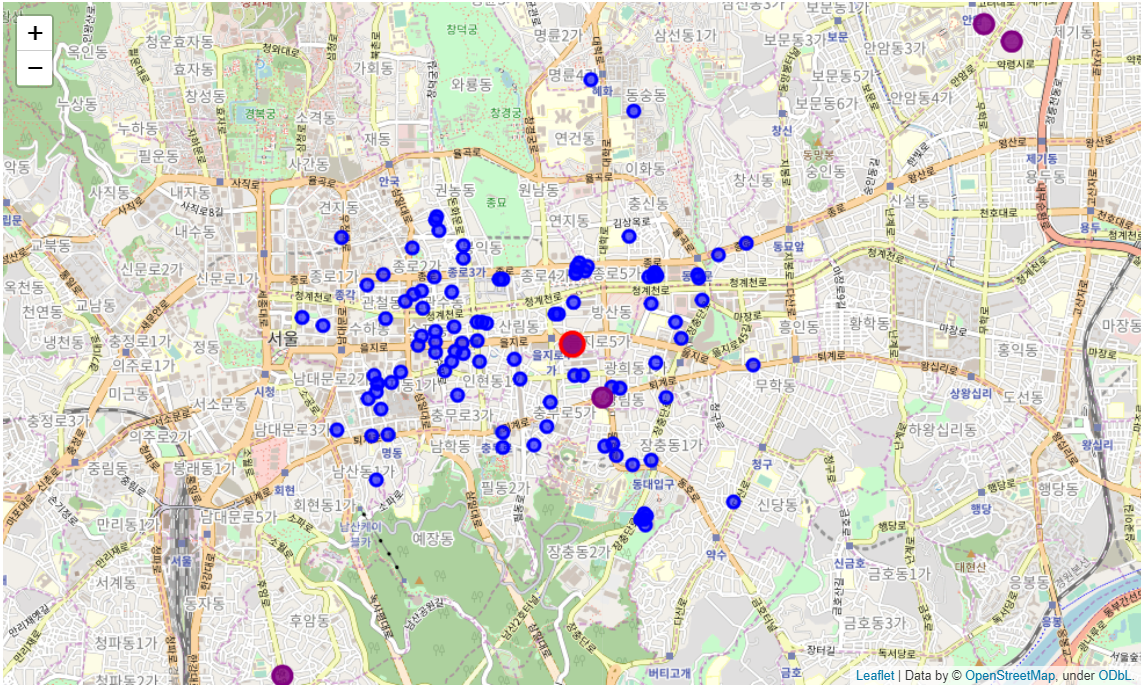

In [23]:
from PIL import Image
image = Image.open('./map_seoul.png')
image